# Segment Blood Vessels
by Jeff Benshetler  
## Goal: Segment blood vessel images. 
### Inputs: 
  - Gray scale image from which to segement blood vessels
  - Regions image, a version of gray scale image with a red boundary identifying the type of region to segment.
### Output:
Gray scale image with white indicating that pixel is categorized as a blood vessel, black otherwise. 

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
from numpy.typing import NDArray
from typing import List, Tuple

In [3]:
def print_info(name : str, var : NDArray ) -> None:
    print(f"{name}.shape={var.shape} {name}.dtype={var.dtype}")

In [4]:
def show_image(img : NDArray, title : str, dpi : int = 90) -> None:
    plt.figure(figsize=(16,9), dpi=dpi)
    _ = plt.imshow(img)
    _ = plt.title(title) 

In [5]:
img = cv2.imread('input/input.png')
print_info('input',img)

img.shape=(400, 322, 3) img.dtype=uint8


In [6]:
regions_img = cv2.cvtColor(
    cv2.imread('input/regions.png'),
    cv2.COLOR_RGB2BGR
)
print_info('regions_img',regions_img)

regions_img.shape=(400, 322, 3) regions_img.dtype=uint8


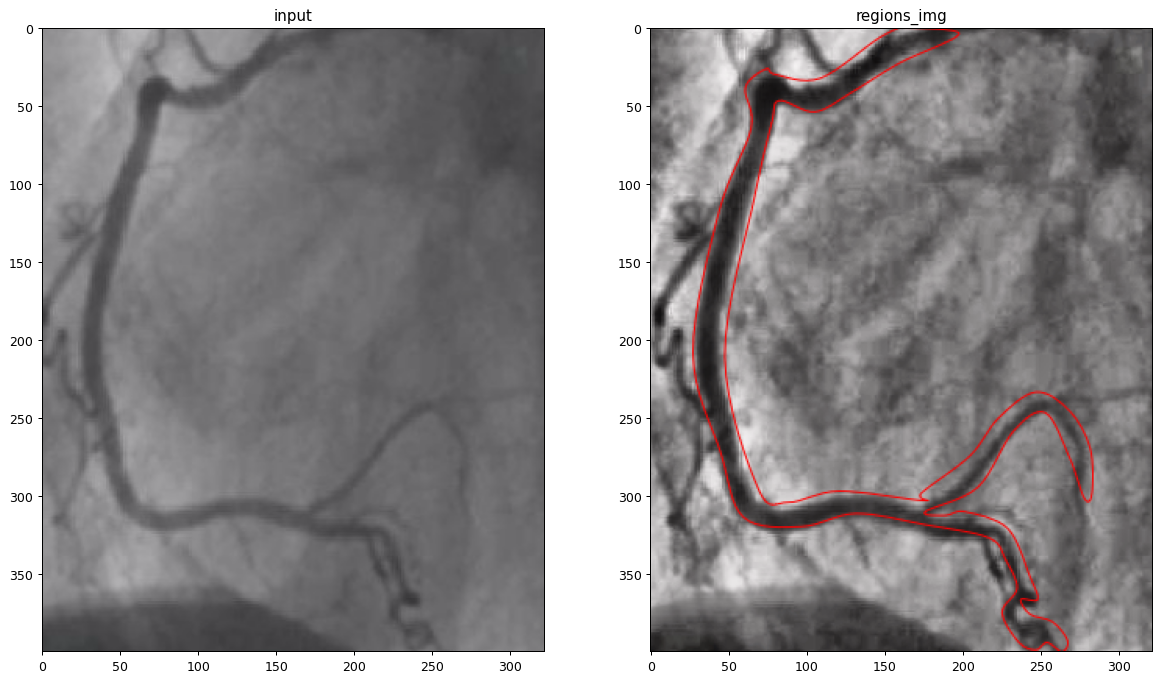

In [7]:
plt.figure(figsize=(16,9), dpi=90)
plt.subplot(1,2,1)
plt.imshow(img)
plt.gca().set_title('input')
plt.subplot(1,2,2)
plt.imshow(regions_img)
plt.gca().set_title('regions_img')
plt.show()

In [8]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = cv2.cvtColor( 
                clahe.apply( 
                    cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
                ), 
                cv2.COLOR_GRAY2RGB
            )
print_info('equalized', equalized)
#cv2.imwrite('equalized.png', equalized)
#print(f"equalized.shape={equalized.shape}")

equalized.shape=(400, 322, 3) equalized.dtype=uint8


In [9]:
def histogram_plot(img : NDArray, title : str = None, dpi : int = 90):
    hist, bins = np.histogram( img.ravel(), bins=256, range=[0,256])
    plt.figure(figsize=(16,9), dpi=dpi)
    plt.plot(bins[:-1], hist / hist.sum())
    if title:
        plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    return bins[:-1], hist

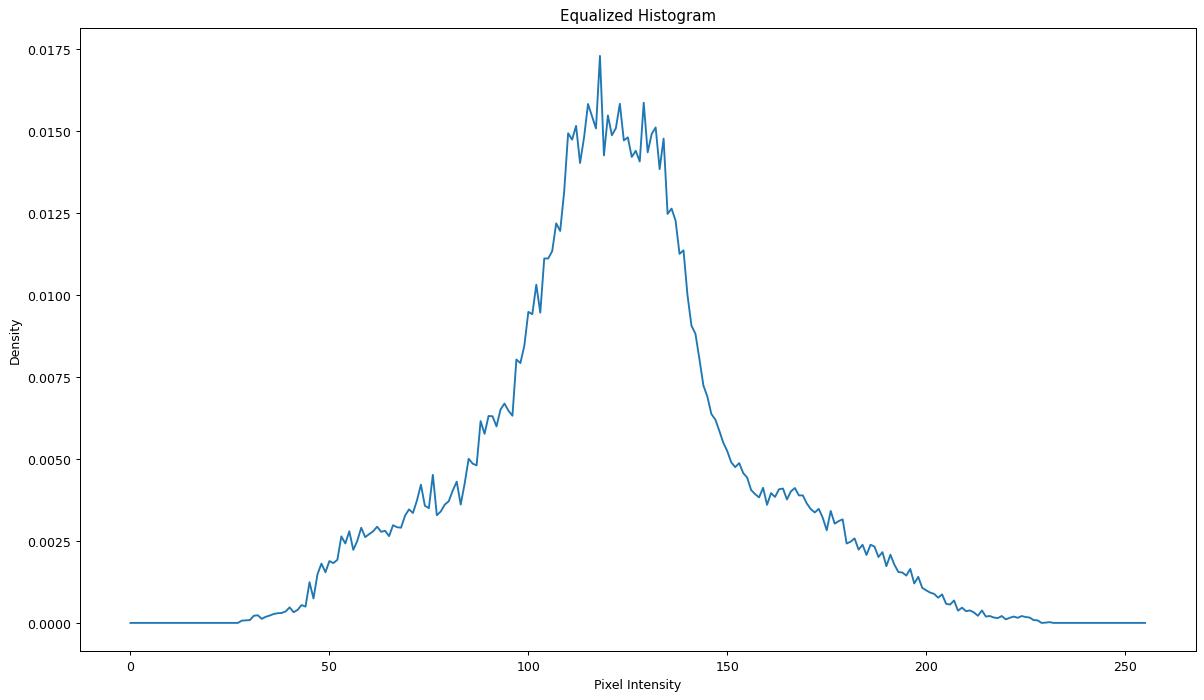

In [10]:
_ = histogram_plot(equalized[:,:,0], "Equalized Histogram")

In [11]:
def show_channels(img : NDArray, suptitle : str = None, subtitles : list = None, dpi : int = 90):
    fig = plt.figure(figsize=(16,9), dpi=dpi)
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        if subtitles:
            plt.gca().set_title(subtitles[i])
        plt.imshow(img[:,:,i], 'gray')
    if suptitle is not None:
        fig.suptitle(suptitle, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

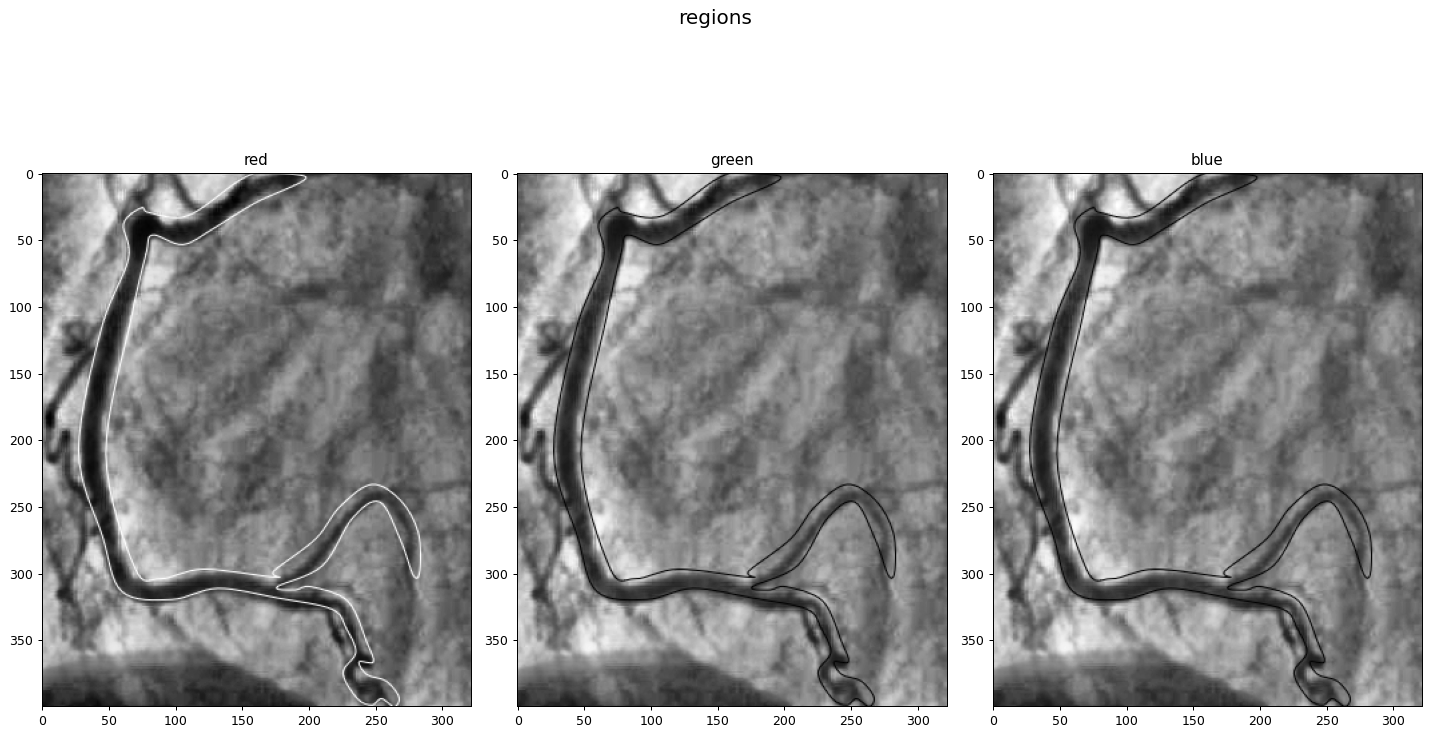

In [12]:
show_channels(regions_img, suptitle="regions", subtitles=['red','green','blue'])

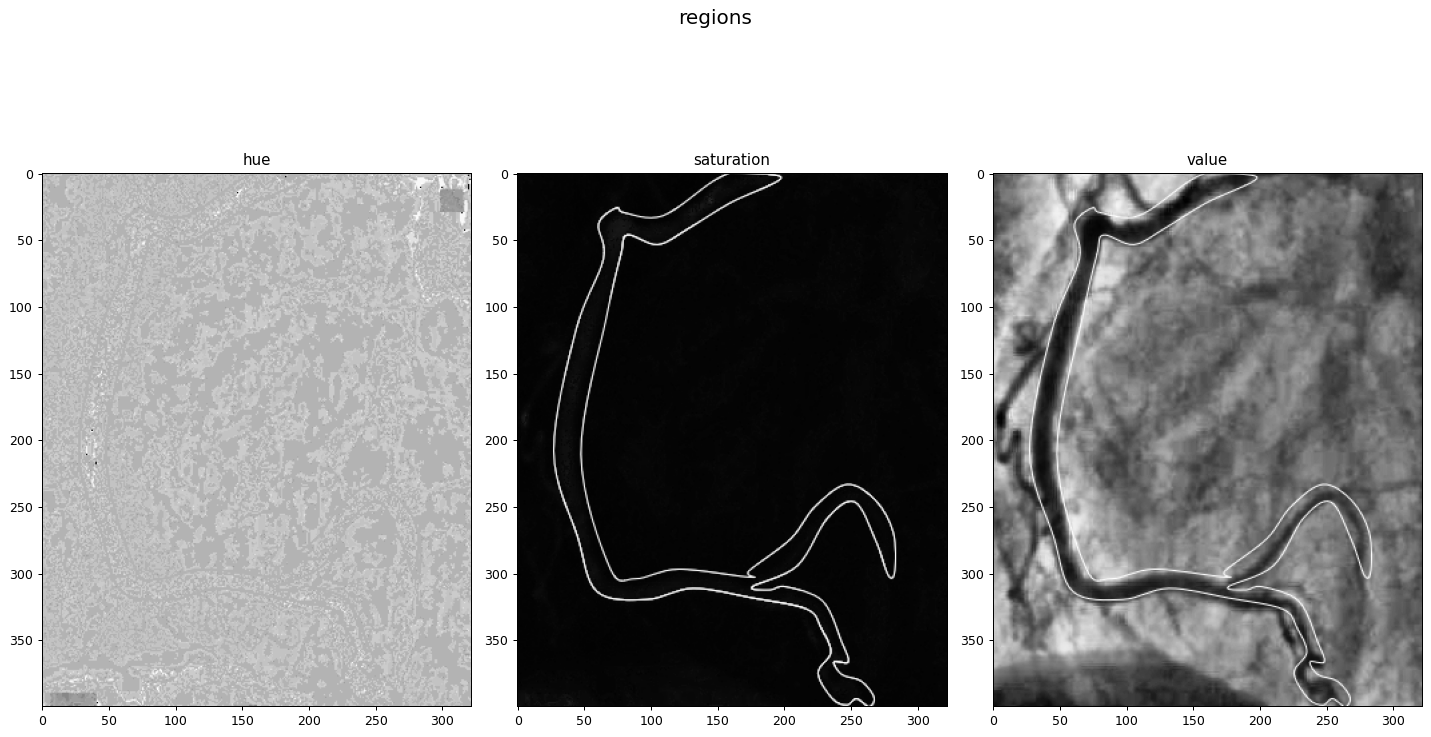

In [13]:
hsv = cv2.cvtColor(regions_img, cv2.COLOR_BGR2HSV)
show_channels(hsv, 'regions', subtitles=['hue', 'saturation', 'value'])

# Find the region boundary contour

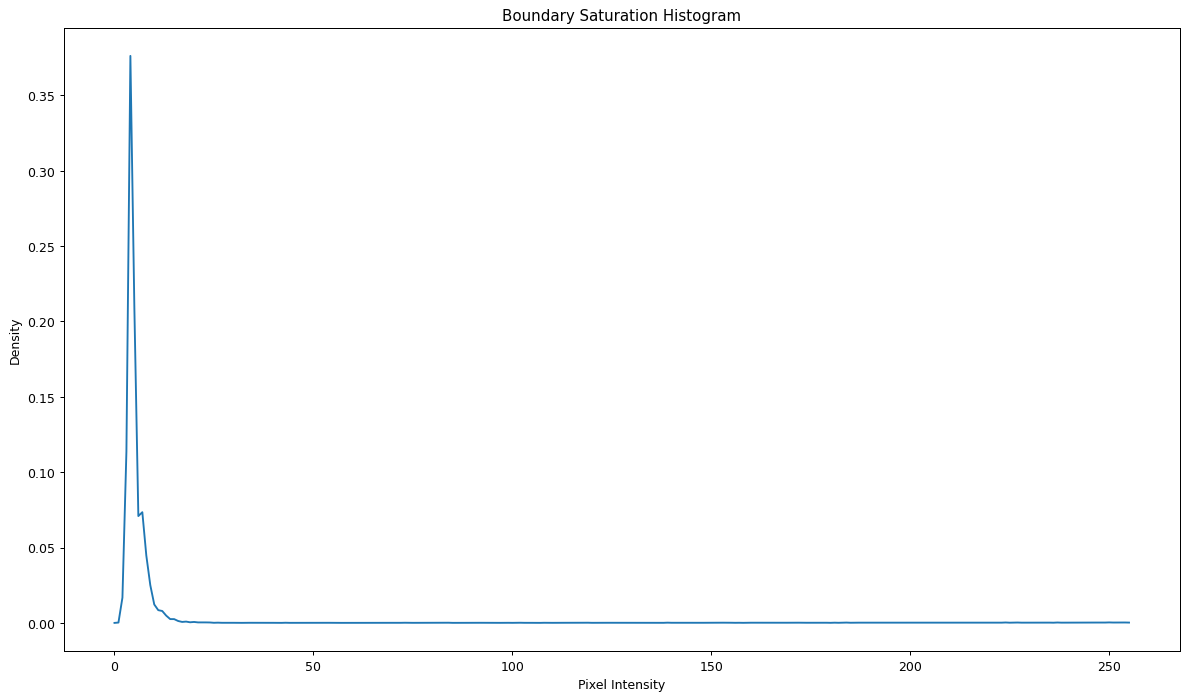

In [14]:
bins, hist = histogram_plot(hsv[:,:,1], "Boundary Saturation Histogram")

## Compute threshold level

In [15]:
percentile = 0.98 # empirically derived
bin_index = np.argmax( np.cumsum(hist) >= percentile*np.sum(hist) )
print(f"Bin={bins[bin_index]} meets or exceens percentile={percentile}")

Bin=119.0 meets or exceens percentile=0.98


## Perform Threshold

Text(0.5, 1.0, 'Thresholded Saturation')

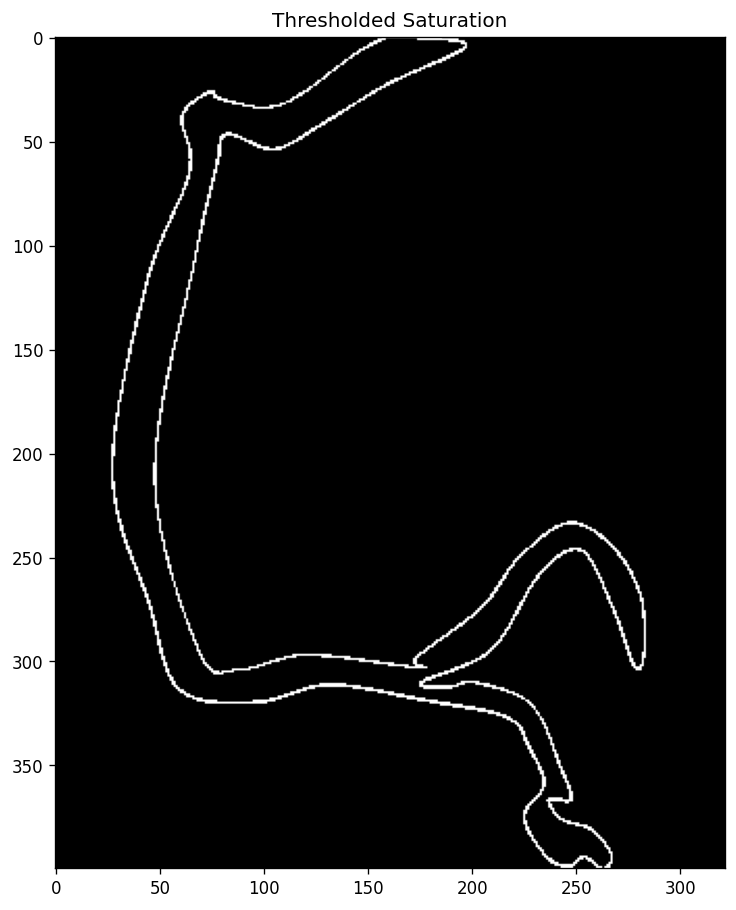

In [16]:
_, saturation_thresholded = cv2.threshold(hsv[:,:,1], bins[bin_index], 255, cv2.THRESH_BINARY)
plt.figure(figsize=(16,9), dpi=120)
plt.imshow(saturation_thresholded, 'grey')
plt.title("Thresholded Saturation")

## Mask for training

In [17]:
contours, hierarchy = cv2.findContours(
    image=np.array(saturation_thresholded, dtype=np.uint8),
    mode=cv2.RETR_CCOMP,
    method=cv2.CHAIN_APPROX_SIMPLE
)

len(contours)=1
contour_img.shape=(400, 322, 3)


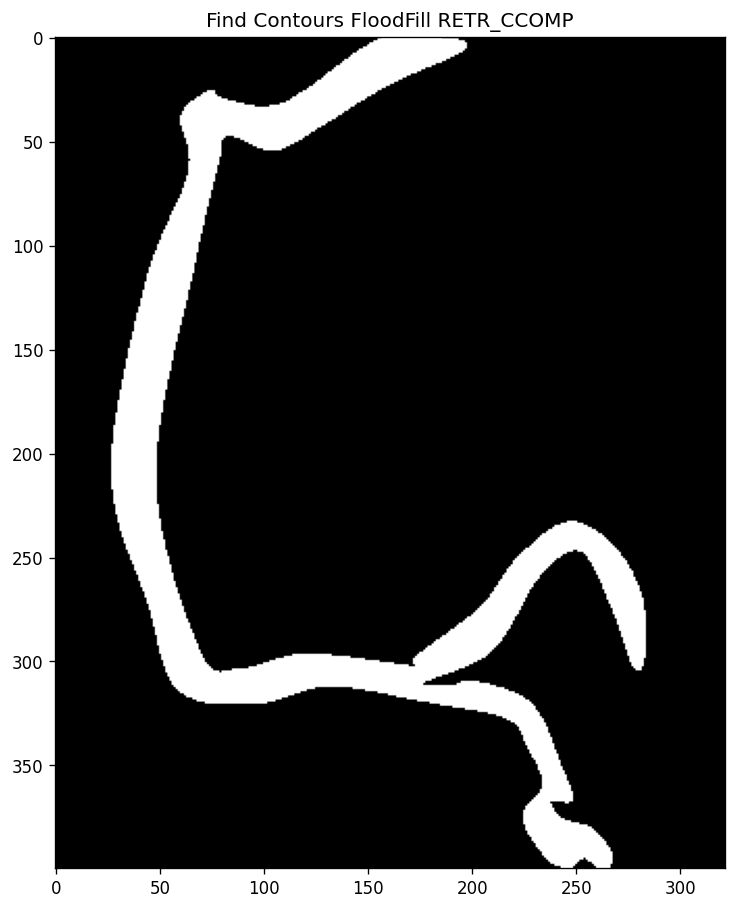

In [18]:
mask = np.zeros(img.shape, np.uint8)
contour_img = cv2.drawContours(
    image=mask, 
    contours=contours, 
    contourIdx=-1, 
    color=(255,255,255), 
    thickness=cv2.FILLED
)

#drawContours FILLED is not working, this is a hack
cv2.floodFill(contour_img, None, seedPoint=(56,105), newVal=(255,255,255), loDiff=(0,0,0,0), upDiff=(0,0,0,0))

print(f"len(contours)={len(contours)}")
plt.figure(figsize=(16,9), dpi=120)
_ = plt.imshow(mask, 'gray')
plt.title("Find Contours FloodFill RETR_CCOMP")
print(f"contour_img.shape={contour_img.shape}")

# Graphcut Segmentation  
Combining `GC_INIT_WITH_RECT` with `GC_INIT_WITH_MASK`  
https://stackoverflow.com/questions/24629794/opencv-grabcut-how-to-combine-gc-init-with-rect-and-gc-init-with-mask

In [97]:
def graphCutSeg(img : NDArray, roi_mask : NDArray, known_fgd : bool = False):
    plt.figure(figsize=(16,9), dpi=120)
    # plt.subplot(2,3,1)
    # plt.imshow(img)
    
    rows,cols,_ = img.shape
    mask = np.ones((rows,cols), np.uint8) * cv2.GC_PR_BGD
    input_mask = cv2.cvtColor( roi_mask.copy(), cv2.COLOR_RGB2GRAY )
    if known_fgd:
        mask[input_mask>0] = cv2.GC_FGD
    else:
        mask[input_mask>0] = cv2.GC_PR_FGD 

    print_info('img', img)
    print_info('mask', mask)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    x0,y0 = ( int(cols/2),int(rows/2) )
    x1,y1 = ( cols-1, rows-1 )
    rect = (x0, y0, x1-x0, y1-y0)
    iter = 5
    cv2.grabCut(
        img,
        mask,
        rect,
        bgdModel,
        fgdModel,
        iter,
        cv2.GC_INIT_WITH_MASK
    )
    same = np.abs(input_mask - mask)
    changes = np.ones((rows,cols),np.uint8) * 255
    changes[ np.where(input_mask == mask)] = 0
    
    plt.subplot(1,3,1)
    plt.imshow(roi_mask,'gray')
    plt.gca().set_title("Region Of Interest")
    
    plt.subplot(1,3,2)
    plt.imshow(mask, 'gray')
    plt.gca().set_title('Result')
    
    plt.subplot(1,3,3)
    plt.imshow(same,'gray')
    plt.gca().set_title('same')
    
    plt.show()

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


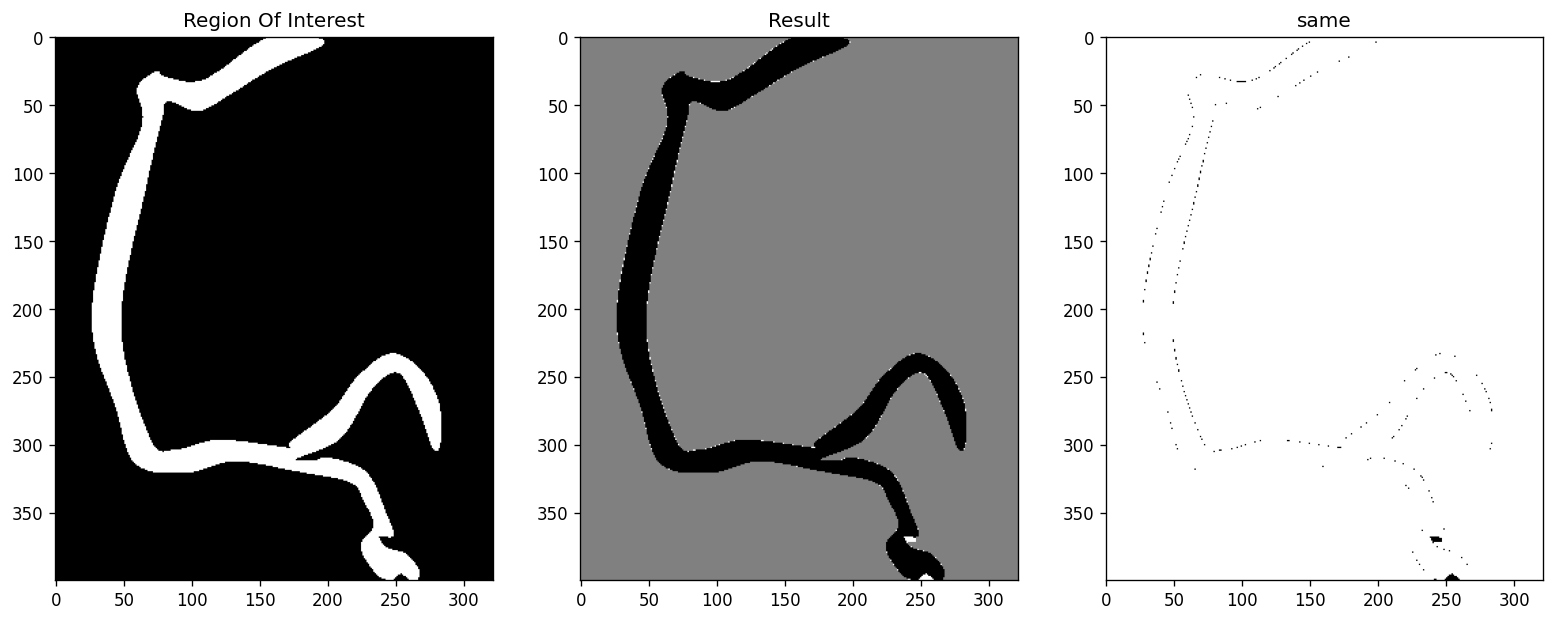

In [98]:
graphCutSeg(regions_img, mask, True)

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


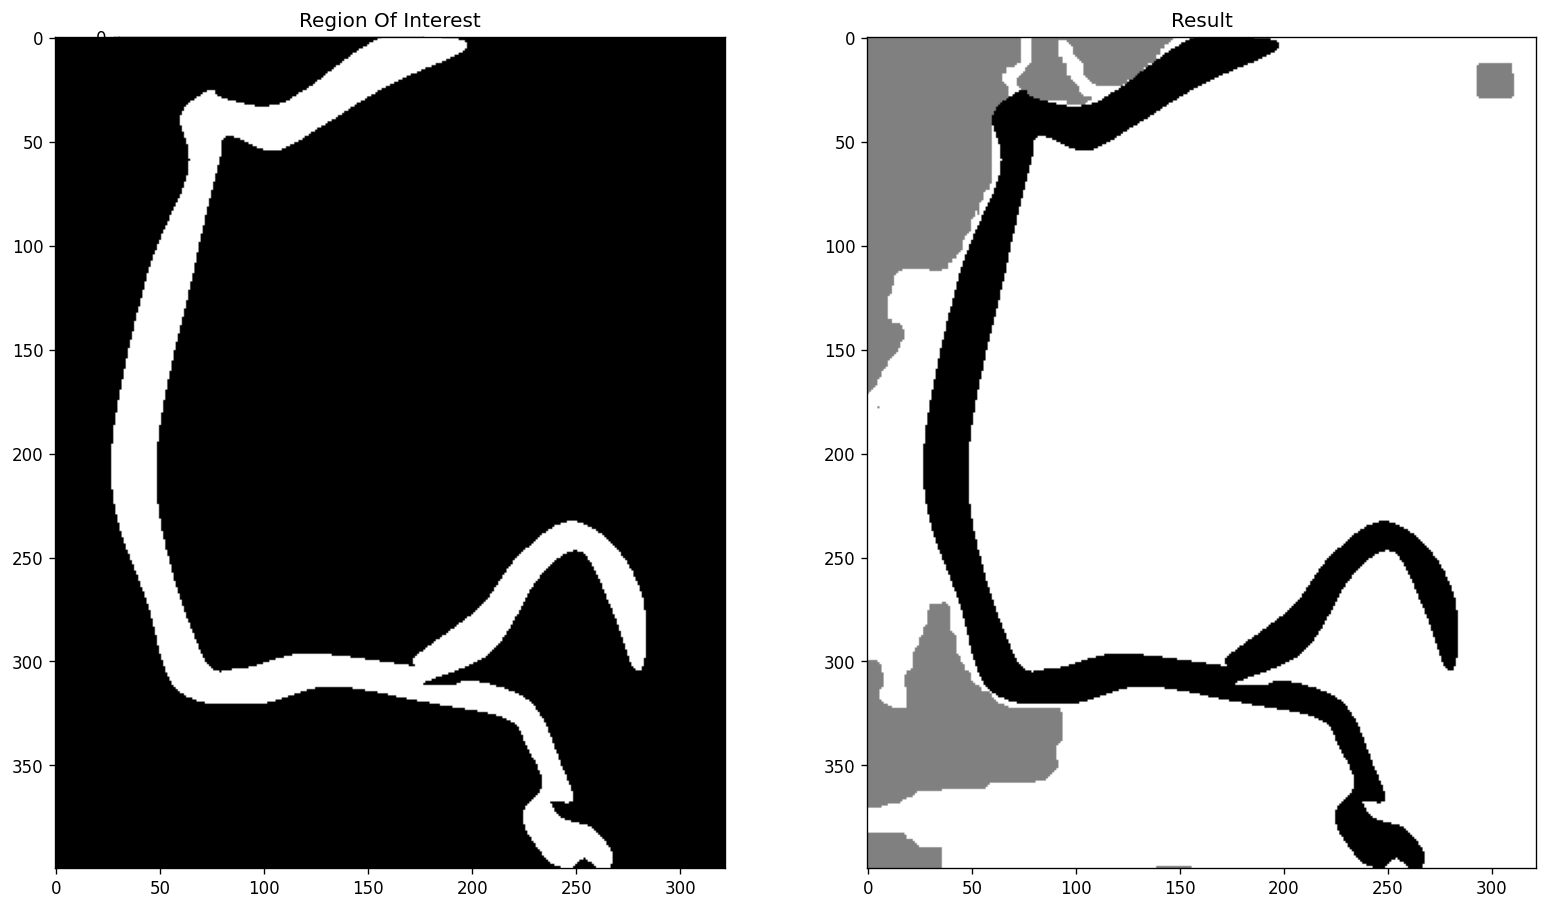

In [56]:
graphCutSeg(img, mask, True)

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


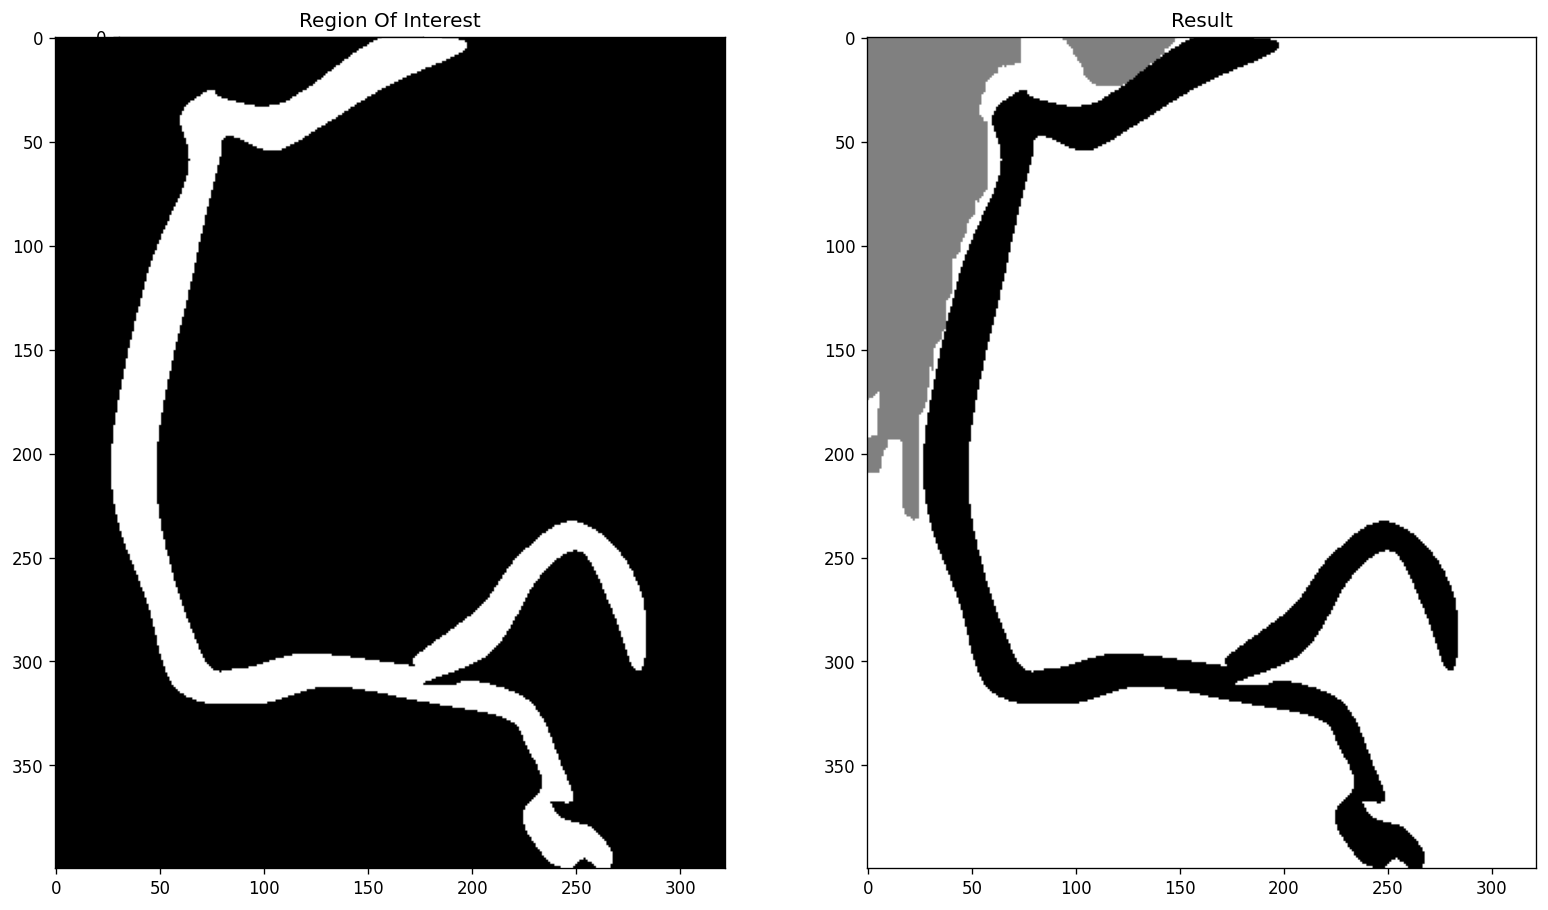

In [57]:
graphCutSeg(equalized, mask, True)

How to reuse models from grabcut in OpenCV  
https://stackoverflow.com/questions/66476128/how-to-reuse-models-from-grabcut-in-opencv

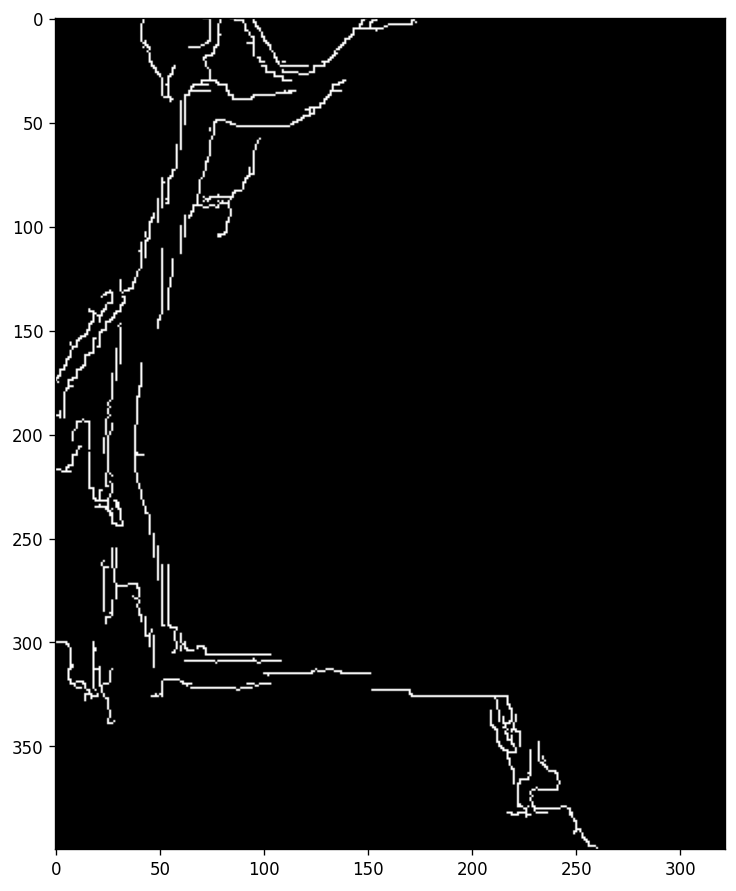

In [48]:
edges = np.zeros(equalized.shape[:2])
edges = cv2.Canny(equalized, 50, 180, edges, apertureSize=3, L2gradient=True)
plt.figure(figsize=(16,9),dpi=120)
plt.imshow(edges,'gray')

# Ideas
+ Mutual Information
+ Local variance https://stackoverflow.com/questions/66975708/sliding-window-on-an-image-to-calculate-variance-of-pixels-in-that-window
+ Morphology
+ floodfill with boundaries set by MI


In [60]:
def sobel(img : NDArray) -> NDArray:
    ddepth = cv2.CV_16S
    scale = 1
    delta = 0
    ksize = 3
    grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)


    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

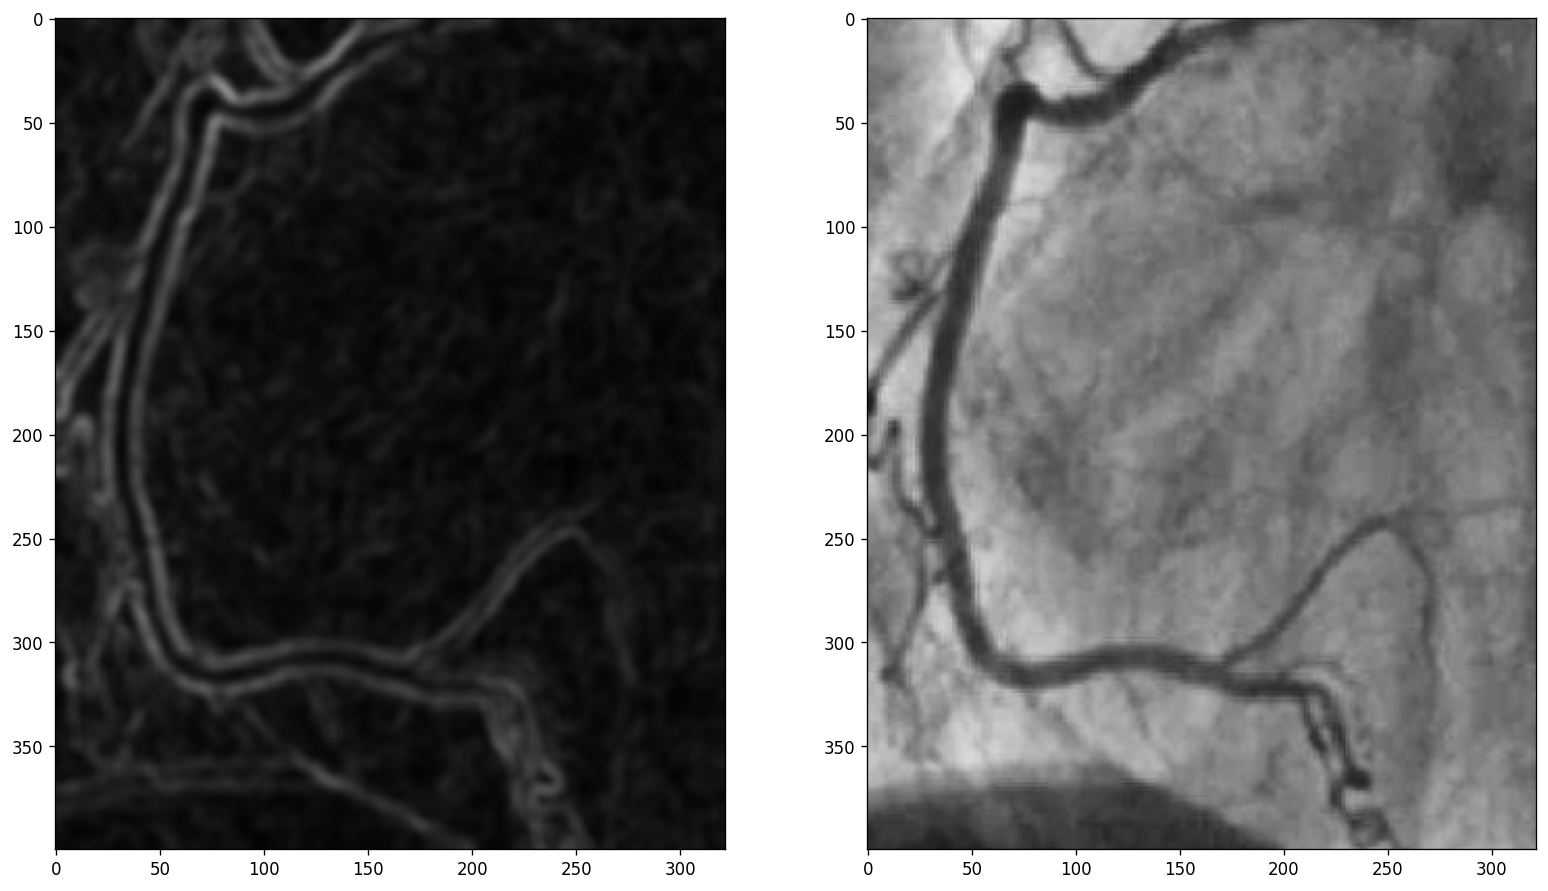

In [69]:
grad = cv2.GaussianBlur( sobel( equalized ),(7,7),3.0) 
plt.figure(figsize=(16,9), dpi=120)
plt.subplot(1,2,1)
plt.imshow(grad, 'gray')
plt.subplot(1,2,2)
plt.imshow(equalized, 'gray')
plt.show()

img.shape=(400, 322, 3) img.dtype=uint8
mask.shape=(400, 322) mask.dtype=uint8


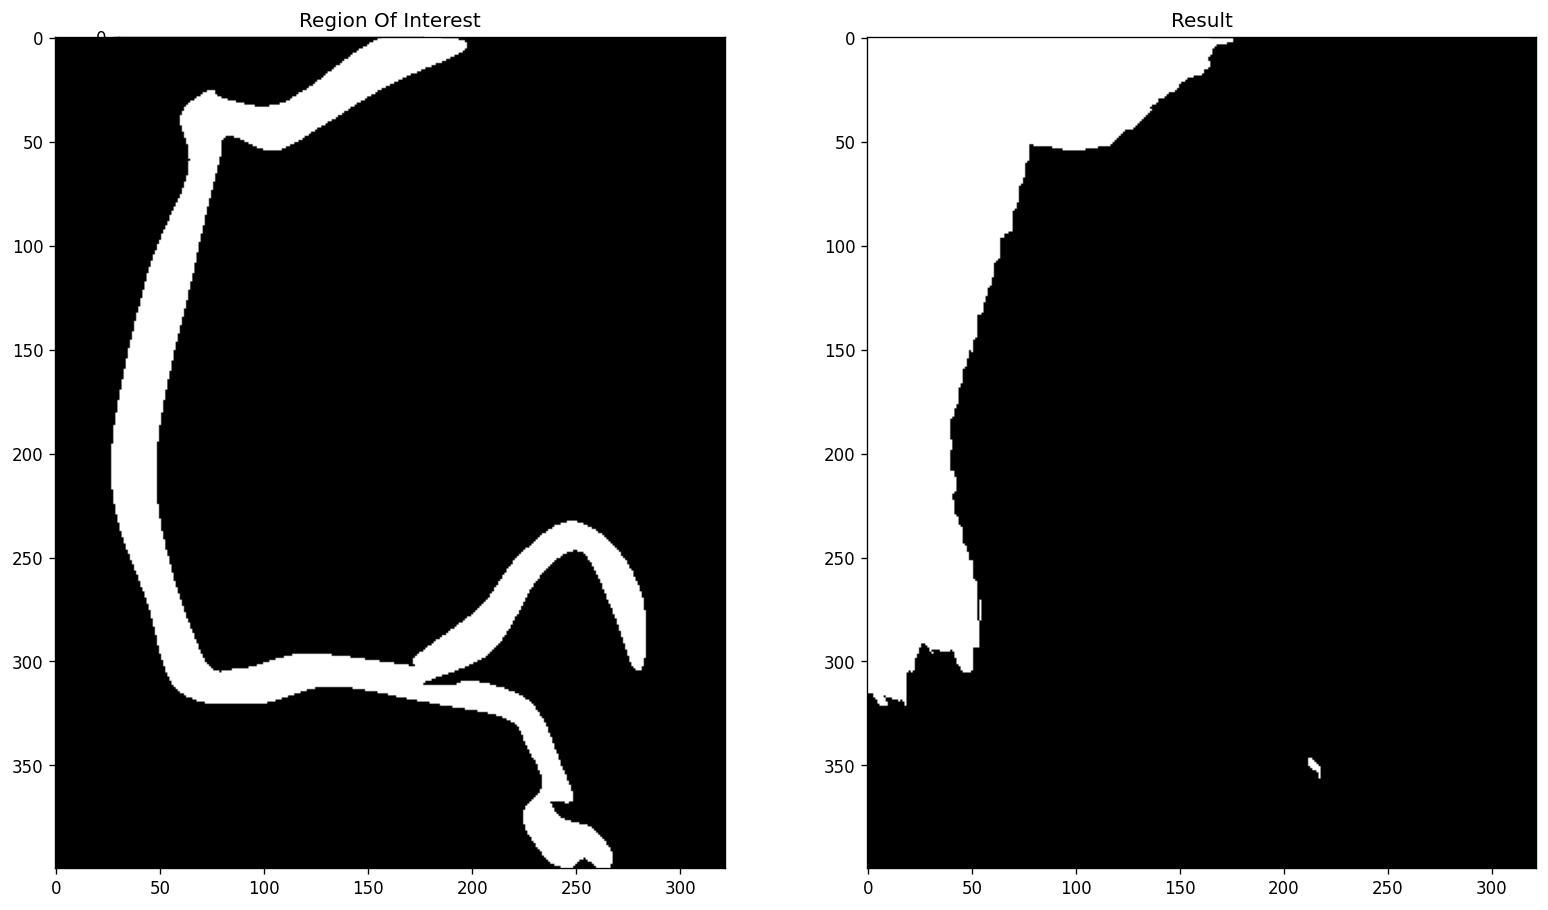

In [59]:
graphCutSeg(grad.astype(np.uint8), mask)

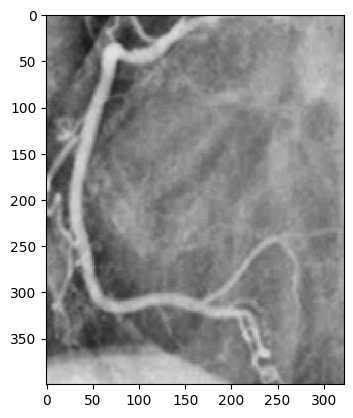

In [72]:
negative = cv2.bitwise_not(equalized)
plt.imshow( negative ) 

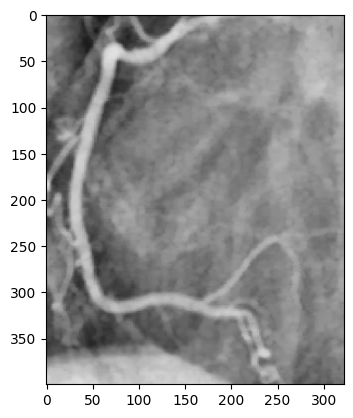

In [79]:
r1 = cv2.morphologyEx(negative, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,3)), iterations = 1)
plt.imshow(r1)

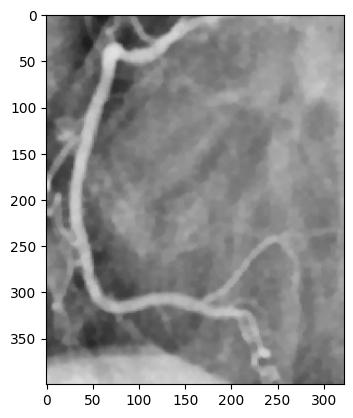

In [74]:
r2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
plt.imshow(r2)

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
        143., 144., 145., 146., 147., 

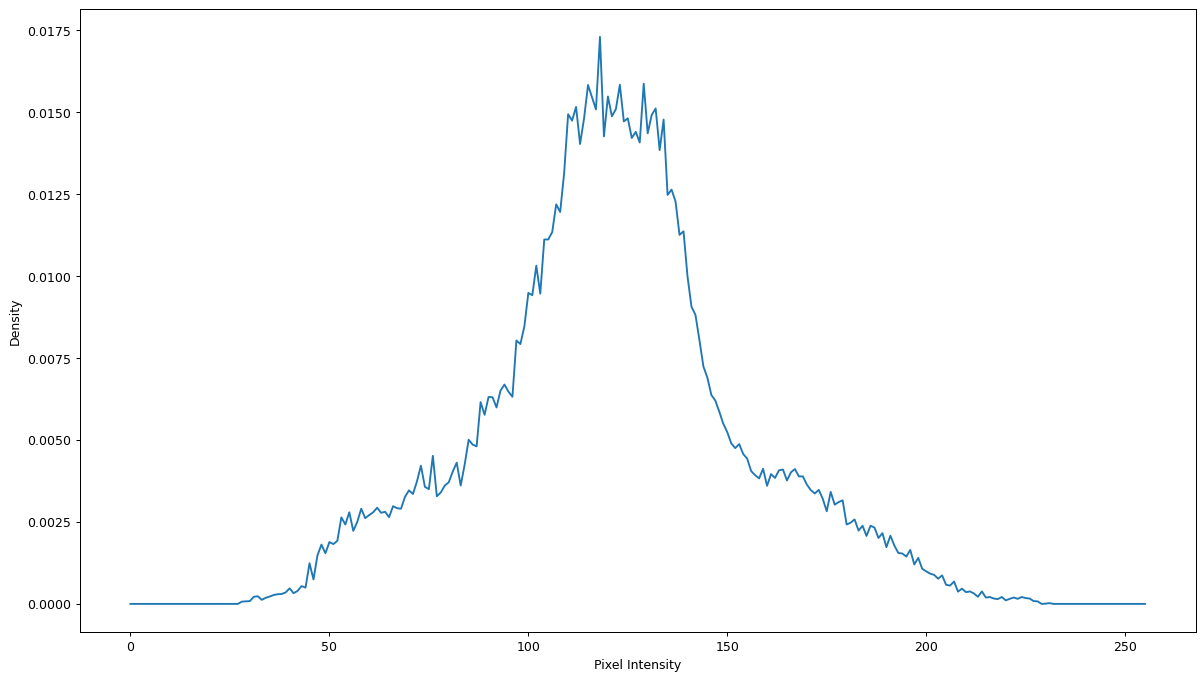

In [99]:
histogram_plot(equalized)

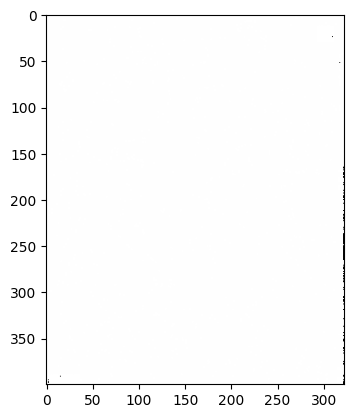

In [117]:
plt.imshow( np.abs( img[:,:,1] - img[:,:,2] ), 'gray' )

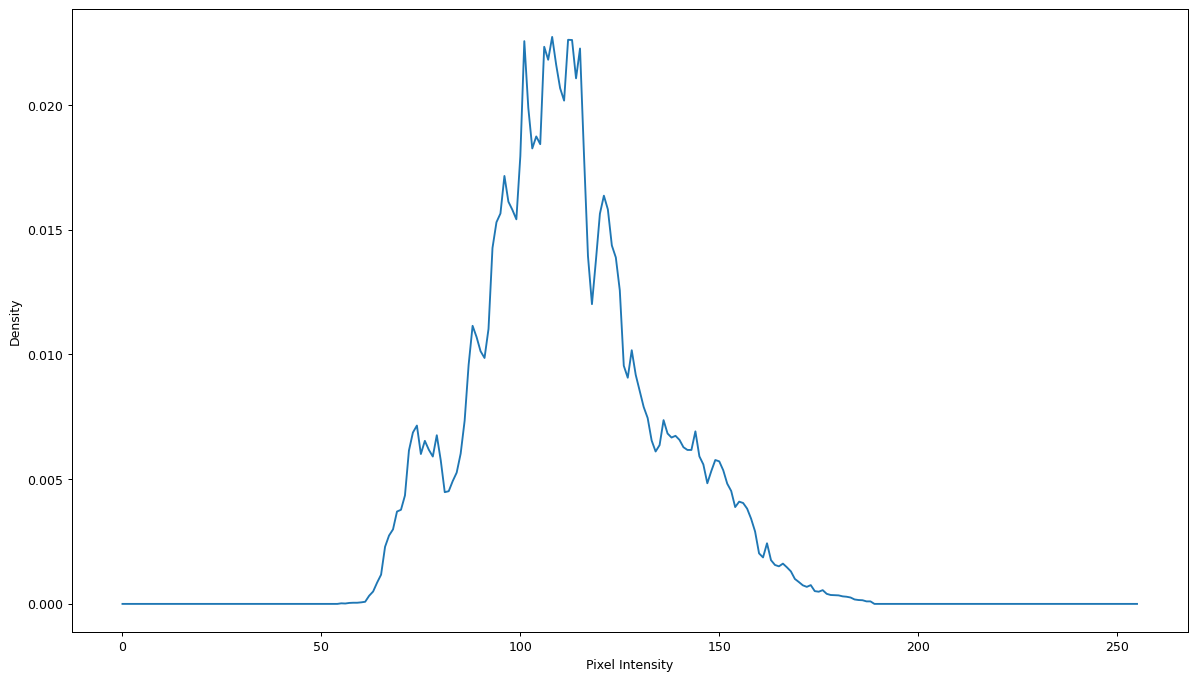

In [106]:
_ = histogram_plot(img[:,:,0])

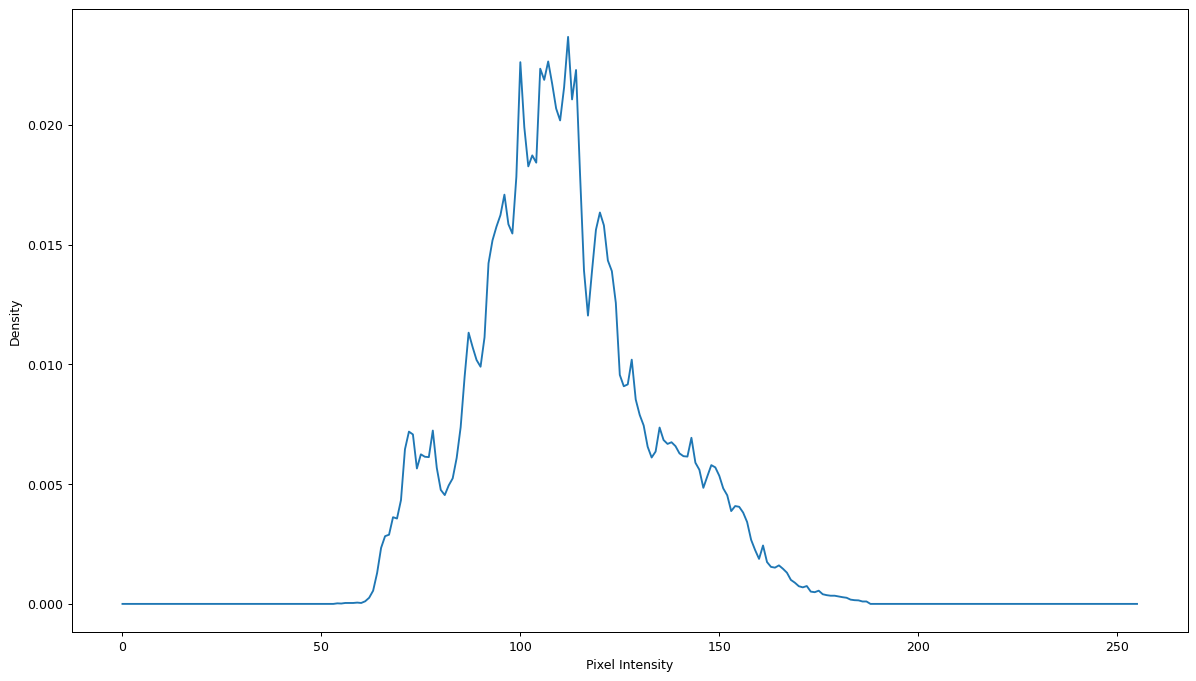

In [107]:
_ = histogram_plot(img[:,:,1])